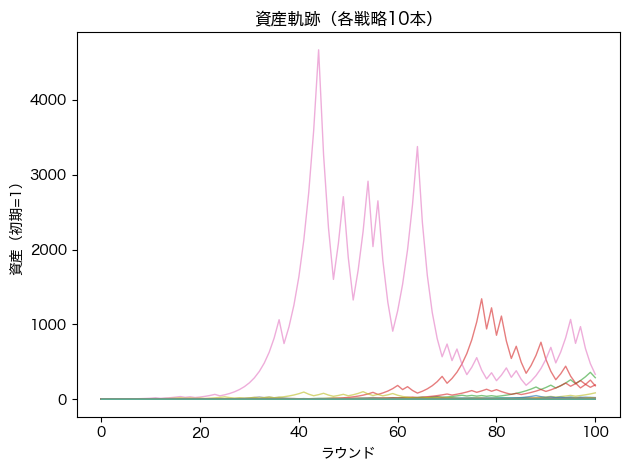

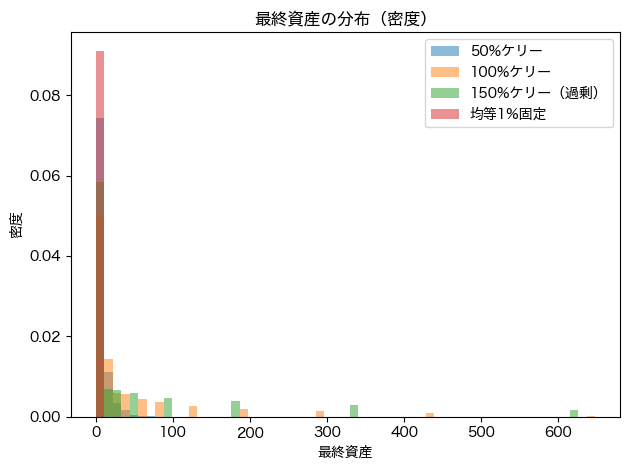

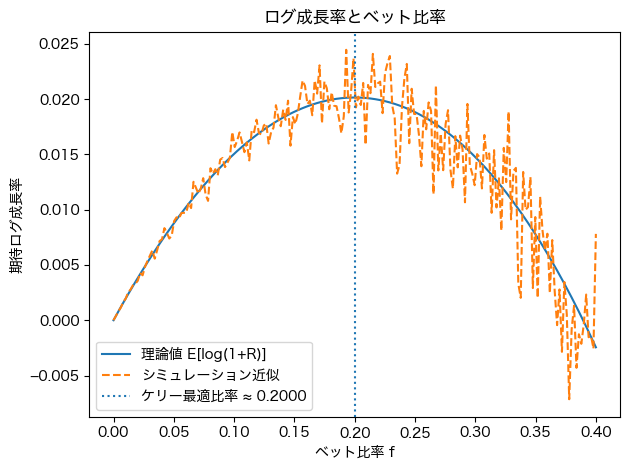

OSError: [Errno 30] Read-only file system: '/data'

In [11]:
# Kelly Criterion Monte Carlo Simulation (Japanese labels)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'Hiragino Sans'  # macOSの場合
#from caas_jupyter_tools import display_dataframe_to_user

rng = np.random.default_rng(42)

# Assumptions (変更可能):
p = 0.6          # 勝率
b = 1           # 配当オッズ（1 = イーブン）
n_rounds = 100    # ベット回数
n_paths = 20000    # モンテカルロ本数
initial_wealth = 1

# ケリー比率
f_kelly = (b * p - (1 - p)) / b  # = 2p - 1 when b=1
fractions = {
    "0%（ベットなし）": 0.0,
    "50%ケリー": 0.5 * f_kelly,
    "100%ケリー": f_kelly,
    "150%ケリー（過剰）": 1.5 * f_kelly,
    "均等1%固定": 0.01,  # 参考比較：固定1%ベット
}

# 1パスの推移を計算する関数（複利）
def simulate_path(fraction, p, b, n_rounds, initial_wealth):
    W = np.empty(n_rounds + 1)
    W[0] = initial_wealth
    # 勝敗はあらかじめ生成（効率化）
    outcomes = rng.uniform(size=n_rounds) < p  # True=勝ち, False=負け
    for t in range(n_rounds):
        f = fraction
        # 破産防止のためのクリップ（-100%を避ける）
        f = np.clip(f, -0.99, 0.99)
        if outcomes[t]:
            r = f * b  # 勝ちのリターン（掛け金fに対しb倍の利益）
        else:
            r = -f     # 負けのリターン（掛け金分の損失）
        W[t + 1] = W[t] * (1 + r)
    return W

def simulate_many(fraction, label):
    wealth_paths = np.vstack([simulate_path(fraction, p, b, n_rounds, initial_wealth) for _ in range(n_paths)])
    final_wealth = wealth_paths[:, -1]
    # 最大ドローダウン計算
    peak = np.maximum.accumulate(wealth_paths, axis=1)
    drawdowns = 1 - (wealth_paths / peak)
    max_dd = drawdowns.max(axis=1)

    summary = {
        "戦略": label,
        "勝率p": p,
        "オッズb": b,
        "ケリー比率": f_kelly,
        "採用比率f": fraction,
        "平均最終資産": final_wealth.mean(),
        "中央値最終資産": np.median(final_wealth),
        "5%分位最終資産": np.percentile(final_wealth, 5),
        "95%分位最終資産": np.percentile(final_wealth, 95),
        "平均最大DD": max_dd.mean(),
        "中央値最大DD": np.median(max_dd),
        "DD>50%の確率": (max_dd > 0.5).mean(),
        "資産<初期の確率": (final_wealth < initial_wealth).mean(),
    }
    return wealth_paths, final_wealth, max_dd, summary

results = {}
summaries = []
for label, f in fractions.items():
    wealth_paths, final_wealth, max_dd, summary = simulate_many(f, label)
    results[label] = {
        "paths": wealth_paths,
        "final": final_wealth,
        "max_dd": max_dd
    }
    summaries.append(summary)

summary_df = pd.DataFrame(summaries)
# 表示を見やすく丸め
display_cols = [
    "戦略","採用比率f","勝率p","オッズb","ケリー比率",
    "平均最終資産","中央値最終資産","5%分位最終資産","95%分位最終資産",
    "平均最大DD","中央値最大DD","DD>50%の確率","資産<初期の確率"
]
summary_df = summary_df[display_cols]
summary_df_rounded = summary_df.copy()
for c in ["採用比率f","勝率p","オッズb","ケリー比率",
          "平均最終資産","中央値最終資産","5%分位最終資産","95%分位最終資産",
          "平均最大DD","中央値最大DD","DD>50%の確率","資産<初期の確率"]:
    summary_df_rounded[c] = summary_df_rounded[c].astype(float).round(4)


# サンプル：代表的な軌跡（各戦略10本）
plt.figure()
for label in ["50%ケリー","100%ケリー","150%ケリー（過剰）","均等1%固定"]:
    paths = results[label]["paths"][:10]  # 10本だけ
    for i in range(paths.shape[0]):
        plt.plot(paths[i], alpha=0.6, linewidth=1)
plt.title("資産軌跡（各戦略10本）")
plt.xlabel("ラウンド")
plt.ylabel("資産（初期=1）")
plt.tight_layout()
plt.show()

# 最終資産分布（ヒストグラム、各戦略）
plt.figure()
bins = np.linspace(0, np.percentile(np.concatenate([results[k]["final"] for k in results]), 99), 60)
for label in ["50%ケリー","100%ケリー","150%ケリー（過剰）","均等1%固定"]:
    plt.hist(results[label]["final"], bins=bins, alpha=0.5, label=label, density=True)
plt.title("最終資産の分布（密度）")
plt.xlabel("最終資産")
plt.ylabel("密度")
plt.legend()
plt.tight_layout()
plt.show()

# ログ資産の期待成長率（理論値とシミュレーション比較）
def log_growth(f):
    q = 1 - p
    # 勝ち: log(1 + f*b), 負け: log(1 - f)
    # 非現実なfに対してlog未定義にならないように制限
    if f <= -0.99 or f >= 0.99:
        return np.nan
    return p*np.log(1 + f*b) + q*np.log(1 - f)

f_grid = np.linspace(0, min(0.99, f_kelly*2.0), 200)
g_theory = np.array([log_growth(f) for f in f_grid])

# シミュレーションで近似（各fで10000試行の平均）
def sim_log_growth(f, trials=10000):
    wins = rng.uniform(size=trials) < p
    r = np.where(wins, f*b, -f)
    return np.mean(np.log(1 + r))

g_sim = np.array([sim_log_growth(f) for f in f_grid])

plt.figure()
plt.plot(f_grid, g_theory, label="理論値 E[log(1+R)]")
plt.plot(f_grid, g_sim, linestyle="--", label="シミュレーション近似")
plt.axvline(f_kelly, linestyle=":", label=f"ケリー最適比率 ≈ {f_kelly:.4f}")
plt.title("ログ成長率とベット比率")
plt.xlabel("ベット比率 f")
plt.ylabel("期待ログ成長率")
plt.legend()
plt.tight_layout()
plt.show()

# 要約CSVの保存
csv_path = "/data"
summary_df_rounded.to_csv(csv_path, index=False)

csv_path
